In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 94.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:


from roboflow import Roboflow
rf = Roboflow(api_key="DdAFykzvCMpMimBi6ykD")
project = rf.workspace("roboflow-jvuqo").project("football-ball-detection-rejhg")
version = project.version(4)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-ball-detection-4 in yolov8:: 100%|██████████| 9908/9908 [01:52<00:00, 88.20it/s] 


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="DdAFykzvCMpMimBi6ykD")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
dataset = project.version(4).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-4 in yolov8:: 100%|██████████| 522/522 [00:10<00:00, 51.88it/s]


In [ ]:
# merge_and_balance_yolo.py
import os, shutil, random, math, glob
from tqdm import tqdm
import cv2
import yaml
import numpy as np

# ---------- Dependencies ----------
# pip install albumentations opencv-python-headless PyYAML tqdm
import albumentations as A

# ---------- CONFIG ----------
# مسیرها را مطابق محیط خودت تنظیم کن:
BALL_IMAGES_DIR = "/content/drive/MyDrive/football-ball-detection-4"   # or root where images/labels are
PLAYERS_IMAGES_DIR = "/content/drive/MyDrive/football-players-detection-4"
OUTPUT_DIR = "/content/drive/MyDrive/merged_football_dataset"
# اگر بازیکن‌ها باید مپ شوند، اینجا بدید؛ در غیر اینصورت None (رعایت کن که نگه می‌داریم 1,2,3 اگر هستند)
player_class_mapping = None  # e.g. { "0": "1", "1":"2", "2":"3" }  (strings or ints)
# split اگر دیتاست‌های جدا ندارند:
SPLIT = (0.8, 0.1, 0.1)  # train,val,test
RANDOM_SEED = 42

# augment config
AUG_TRANSFORM = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.88,1.12), rotate=(-15,15), p=0.7), # Using Affine instead of ShiftScaleRotate
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.0))

# ---------- Helper functions ----------
def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def list_images_labels(root):
    """Detect images and labels. Accepts either dataset_root/images/*.jpg & dataset_root/labels/*.txt
       or dataset_root/train/images/ etc. Returns list of tuples (image_path, label_path, subset)"""
    out=[]
    subsets = ['train','valid','val','test']
    found_subset = False
    for s in subsets:
        img_dir = os.path.join(root, s, "images")
        lbl_dir = os.path.join(root, s, "labels")
        if os.path.isdir(img_dir):
            found_subset = True
            for img in glob.glob(os.path.join(img_dir, "*")):
                base = os.path.splitext(os.path.basename(img))[0]
                lbl = os.path.join(lbl_dir, base + ".txt")
                out.append((img, lbl, s if s!='valid' else 'val'))
    if not found_subset:
        # try images/ and labels/ at root
        img_dir = os.path.join(root, "images")
        lbl_dir = os.path.join(root, "labels")
        if os.path.isdir(img_dir):
            for img in glob.glob(os.path.join(img_dir,"*")):
                base = os.path.splitext(os.path.basename(img))[0]
                lbl = os.path.join(lbl_dir, base + ".txt")
                out.append((img,lbl,'none'))
        else:
            # also accept root/*.jpg
            for img in glob.glob(os.path.join(root,"*")):
                if img.lower().endswith(('.jpg','.jpeg','.png')):
                    base = os.path.splitext(os.path.basename(img))[0]
                    lbl = os.path.join(root,"labels", base + ".txt")
                    out.append((img,lbl,'none'))
    return out

def read_yolo_label(path):
    boxes=[]
    if not os.path.exists(path):
        return boxes
    with open(path,'r') as f:
        for line in f:
            s=line.strip()
            if not s: continue
            parts = s.split()
            if len(parts) == 4:
                # no class -> we'll handle upstream by assigning default class
                x,y,w,h = map(float, parts)
                boxes.append([None, x,y,w,h])
            elif len(parts) >=5:
                cls = int(float(parts[0]))
                x,y,w,h = map(float, parts[1:5])
                boxes.append([cls, x,y,w,h])
    return boxes

def write_yolo_label(path, boxes):
    with open(path,'w') as f:
        for cls,x,y,w,h in boxes:
            f.write(f"{int(cls)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

def copy_with_prefix(img_src, lbl_src, out_img_dir, out_lbl_dir, prefix, idx):
    ext = os.path.splitext(img_src)[1]
    out_imgname = f"{prefix}_{idx}{ext}"
    out_img = os.path.join(out_img_dir, out_imgname)
    shutil.copy2(img_src, out_img)
    out_lbl = os.path.join(out_lbl_dir, os.path.splitext(out_imgname)[0]+".txt")
    if os.path.exists(lbl_src):
        shutil.copy2(lbl_src, out_lbl)
    else:
        open(out_lbl,'w').close()
    return out_img, out_lbl

def sanitize_yolo_bbox(x,y,w,h, eps=1e-6):
    # ensure w,h in (eps,1-eps) and center so that ymin,ymax inside [0,1]
    w = float(max(min(w, 1.0 - eps), eps))
    h = float(max(min(h, 1.0 - eps), eps))
    x = float(min(max(x, w/2 + eps), 1.0 - w/2 - eps))
    y = float(min(max(y, h/2 + eps), 1.0 - h/2 - eps))
    return x,y,w,h

# ---------- Core merging ----------
def merge_datasets(ball_root, player_root, output_root,
                   ball_prefix='ball', player_prefix='pl',
                   player_map=None):
    random.seed(RANDOM_SEED)
    ensure_dir(output_root)
    imgs_out = os.path.join(output_root,"images")
    lbls_out = os.path.join(output_root,"labels")
    ensure_dir(imgs_out); ensure_dir(lbls_out)

    ball_items = list_images_labels(ball_root)
    player_items = list_images_labels(player_root)

    print(f"Found {len(ball_items)} ball images, {len(player_items)} player images (detected splits preserved if any).")

    idx = 0
    index = []  # list of dicts: {img, lbl, classes: [cls...]}
    for img,lbl,subset in tqdm(ball_items, desc="Copy ball"):
        idx += 1
        out_img_name = f"{ball_prefix}_{idx}{os.path.splitext(img)[1]}"
        out_img = os.path.join(imgs_out, out_img_name)
        shutil.copy2(img, out_img)
        out_lbl = os.path.join(lbls_out, os.path.splitext(out_img_name)[0]+".txt")
        # read old label and force class 0
        boxes = read_yolo_label(lbl)
        new_boxes=[]
        for b in boxes:
            _,x,y,w,h = b
            new_boxes.append([0, x,y,w,h])
        write_yolo_label(out_lbl, new_boxes)
        index.append({'img':out_img, 'lbl':out_lbl})

    for img,lbl,subset in tqdm(player_items, desc="Copy players"):
        idx += 1
        out_img_name = f"{player_prefix}_{idx}{os.path.splitext(img)[1]}"
        out_img = os.path.join(imgs_out, out_img_name)
        shutil.copy2(img, out_img)
        out_lbl = os.path.join(lbls_out, os.path.splitext(out_img_name)[0]+".txt")
        # read and apply mapping if any
        boxes = read_yolo_label(lbl)
        new_boxes=[]
        for b in boxes:
            cls,x,y,w,h = b
            if cls is None:
                # ambiguous: assume this is a player bbox with unknown class -> set to 1 (or raise)
                cls = 1
            if player_map:
                cls = int(player_map.get(str(cls), cls))
            new_boxes.append([cls,x,y,w,h])
        write_yolo_label(out_lbl, new_boxes)
        index.append({'img':out_img, 'lbl':out_lbl})

    print(f"Merged total {len(index)} images to {output_root}")
    return index

# ---------- Count distribution ----------
def count_bboxes(index):
    counts = {}
    images_with_class = {}
    for item in index:
        boxes = read_yolo_label(item['lbl'])
        for b in boxes:
            cls = int(b[0])
            counts[cls] = counts.get(cls,0)+1
            images_with_class.setdefault(cls, set()).add(item['img'])
    return counts, images_with_class

# ---------- Augmentation (bbox-safe) ----------
def augment_image_and_save(src_img_path, src_lbl_path, out_img_path, out_lbl_path, n_try=1):
    img = cv2.imread(src_img_path)
    if img is None:
        print("WARN: could not read image", src_img_path); return []
    boxes = read_yolo_label(src_lbl_path)
    if len(boxes)==0:
        # nothing to augment meaningfully; just copy
        shutil.copy2(src_img_path, out_img_path)
        open(out_lbl_path,'w').close()
        return []
    bboxes = []
    class_labels=[]
    for b in boxes:
        cls,x,y,bbw,bbh = b
        if cls is None:
            cls = 0
        # Sanitize input bbox
        x,y,bbw,bbh = sanitize_yolo_bbox(x,y,bbw,bbh)
        bboxes.append([x,y,bbw,bbh])
        class_labels.append(int(cls))

    try:
        augmented = AUG_TRANSFORM(image=img, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']
    except Exception as e:
        print(f"WARN: Augmentation failed for {src_img_path}. Error: {e}. Copying original.")
        shutil.copy2(src_img_path, out_img_path)
        write_yolo_label(out_lbl_path, [[int(cls), x,y,bbw,bbh] for (x,y,bbw,bbh), cls in zip(bboxes, class_labels)])
        return [[int(cls), x,y,bbw,bbh] for (x,y,bbw,bbh), cls in zip(bboxes, class_labels)] # Return original boxes

    new_boxes = []
    for (x,y,bbw,bbh), cls in zip(aug_bboxes, aug_labels):
        # Sanitize output bbox
        x,y,bbw,bbh = sanitize_yolo_bbox(x,y,bbw,bbh)
        new_boxes.append([int(cls), float(x), float(y), float(bbw), float(bbh)])

    cv2.imwrite(out_img_path, aug_img)
    write_yolo_label(out_lbl_path, new_boxes)
    return new_boxes

# ---------- Oversample loop ----------
def oversample_to_balance(index, target_counts, images_with_class, out_dir, prefix_aug="aug"):
    imgs_out = os.path.join(out_dir,"images")
    lbls_out = os.path.join(out_dir,"labels")
    ensure_dir(imgs_out); ensure_dir(lbls_out)
    # Build mapping img->boxes for fast lookup
    img_to_boxes = {}
    for item in index:
        img_to_boxes[item['img']] = read_yolo_label(item['lbl'])
    # For uniqueness
    aug_counter = 0
    # For each class needing augmentation
    counts, _ = count_bboxes(index)
    for cls, target in target_counts.items():
        cur = counts.get(cls,0)
        if cur >= target:
            continue
        print(f"Augmenting class {cls}: {cur} -> {target}")
        candidates = list(images_with_class.get(cls, []))
        if len(candidates)==0:
            print(f" WARNING: no source images for class {cls} to augment. Skipping.")
            continue
        cidx = 0
        while counts.get(cls,0) < target:
            src = random.choice(candidates)
            src_lbl = os.path.join(out_dir.replace("images","labels") if "images" in out_dir else os.path.join(os.path.dirname(src),"../labels"), os.path.splitext(os.path.basename(src))[0]+".txt")
            # better to find actual lbl path in index
            # find lbl in index:
            src_lbl = None
            for it in index:
                if it['img'] == src:
                    src_lbl = it['lbl']; break
            if src_lbl is None:
                print("Could not find label for", src); break
            aug_counter += 1
            out_img_name = f"{prefix_aug}_{cls}_{aug_counter}{os.path.splitext(src)[1]}"
            out_img = os.path.join(imgs_out, out_img_name)
            out_lbl = os.path.join(lbls_out, os.path.splitext(out_img_name)[0]+".txt")
            newboxes = augment_image_and_save(src, src_lbl, out_img, out_lbl)
            # update index and counts and images_with_class
            index.append({'img': out_img, 'lbl': out_lbl})
            for nb in newboxes:
                ncls = int(nb[0])
                counts[ncls] = counts.get(ncls,0)+1
                images_with_class.setdefault(ncls,set()).add(out_img)
            # safety: if infinite loop risk, break after some large tries
            cidx += 1
            if cidx % 500 == 0:
                print("Still augmenting... current counts:", {k:counts.get(k,0) for k in target_counts.keys()})
    return index

# ---------- Utility: build final split and dataset yaml ----------
def split_and_write(index, out_root, split=SPLIT):
    random.shuffle(index)
    n = len(index)
    ntrain = int(split[0]*n)
    nval = int(split[1]*n)
    test = index[ntrain+nval:]
    train = index[:ntrain]
    val = index[ntrain:ntrain+nval]
    # move files into train/val/test subfolders
    for subset, arr in [('train',train), ('val',val), ('test',test)]:
        imgdir = os.path.join(out_root, subset, "images"); lbldir = os.path.join(out_root, subset, "labels")
        ensure_dir(imgdir); ensure_dir(lbldir)
        for it in arr:
            shutil.move(it['img'], os.path.join(imgdir, os.path.basename(it['img'])))
            shutil.move(it['lbl'], os.path.join(lbldir, os.path.basename(it['lbl'])))
    # create dataset yaml
    yaml_path = os.path.join(out_root,"dataset.yaml")
    data = {
        'train': os.path.join(out_root, 'train', 'images'),
        'val': os.path.join(out_root, 'val', 'images'),
        'test': os.path.join(out_root, 'test', 'images'),
        'nc': 4,
        'names': ['ball', 'player_class1', 'player_class2', 'player_class3']
    }
    with open(yaml_path,'w') as f:
        yaml.dump(data,f)
    print("Wrote dataset.yaml to", yaml_path)

# ---------- MAIN execution ----------
if __name__ == "__main__":
    out = OUTPUT_DIR
    ensure_dir(out)
    # 1) Merge
    index = merge_datasets(BALL_IMAGES_DIR, PLAYERS_IMAGES_DIR, out,
                           ball_prefix='ball', player_prefix='pl', player_map=player_class_mapping)
    # 2) Count
    counts, images_with_class = count_bboxes(index)
    print("Initial counts:", counts)
    # 3) target -> max value among present classes (so we oversample others up to this)
    if len(counts)==0:
        print("No bboxes found at all — nothing to balance.")
        exit(1)
    target = max(counts.values())
    # Make dict for classes 0..3 (ensure missing classes present)
    target_counts = {}
    for cls in [0,1,2,3]:
        target_counts[cls] = target
    print("Target per-class bbox count:", target_counts)
    # 4) Oversample by augmentation
    index = oversample_to_balance(index, target_counts, images_with_class, out)
    # 5) final recount
    final_counts, _ = count_bboxes(index)
    print("Final counts after augmentation:", final_counts)
    # 6) split and write
    split_and_write(index, out, split=SPLIT)
    print("Done. Output at:", out)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


AttributeError: module 'albumentations' has no attribute 'ClipBBoxes'

In [ ]:
# patched_augment_resume.py  -- Run this cell in Colab (or local)
import os, glob, random, shutil
from tqdm import tqdm
import cv2
import numpy as np
import albumentations as A
import yaml

# ---------------- CONFIG ----------------
OUTPUT_DIR = "/content/drive/MyDrive/merged_football_dataset"  # همان پوشه‌ای که قبلاً ساخته شد
SKIP_MERGE = True   # <<< اگر قبلاً merge انجام شده، این را True بگذار تا مرحلهٔ merge از اجرا کشیده شود
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# جدید: از Affine به جای ShiftScaleRotate برای حذف warning
AUG_TRANSFORM = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.88,1.12), rotate=(-15,15), p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.0))

# ---------------- utilities ----------------
def ensure_dir(d): os.makedirs(d, exist_ok=True)

def read_yolo_label(path):
    boxes=[]
    if not os.path.exists(path):
        return boxes
    with open(path,'r') as f:
        for line in f:
            s=line.strip()
            if not s: continue
            parts = s.split()
            if len(parts) >= 5:
                cls = int(float(parts[0]))
                x,y,w,h = map(float, parts[1:5])
                boxes.append([cls, x,y,w,h])
            elif len(parts) == 4:
                x,y,w,h = map(float, parts)
                boxes.append([None, x,y,w,h])
    return boxes

def write_yolo_label(path, boxes):
    with open(path,'w') as f:
        for cls,x,y,w,h in boxes:
            f.write(f"{int(cls)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

def load_index_from_output(output_root):
    imgs_dir = os.path.join(output_root, "images")
    lbls_dir = os.path.join(output_root, "labels")
    items = []
    if not os.path.isdir(imgs_dir) or not os.path.isdir(lbls_dir):
        # maybe already split into train/val/test
        for subset in ("train","val","test"):
            s_imgs = os.path.join(output_root, subset, "images")
            s_lbls = os.path.join(output_root, subset, "labels")
            if os.path.isdir(s_imgs):
                for img in glob.glob(os.path.join(s_imgs,"*")):
                    base = os.path.splitext(os.path.basename(img))[0]
                    lbl = os.path.join(s_lbls, base + ".txt")
                    items.append({'img': img, 'lbl': lbl})
        return items
    for img in glob.glob(os.path.join(imgs_dir,"*")):
        base = os.path.splitext(os.path.basename(img))[0]
        lbl = os.path.join(lbls_dir, base + ".txt")
        items.append({'img': img, 'lbl': lbl})
    return items

def count_bboxes(index):
    counts = {}
    images_with_class = {}
    for item in index:
        boxes = read_yolo_label(item['lbl'])
        for b in boxes:
            cls = int(b[0]) if b[0] is not None else 0
            counts[cls] = counts.get(cls,0)+1
            images_with_class.setdefault(cls,set()).add(item['img'])
    return counts, images_with_class

# ----------------- bbox sanitization -----------------
def sanitize_yolo_bbox(x,y,w,h, eps=1e-6):
    # ensure w,h in (eps,1-eps) and center so that ymin,ymax inside [0,1]
    w = float(max(min(w, 1.0 - eps), eps))
    h = float(max(min(h, 1.0 - eps), eps))
    x = float(min(max(x, w/2 + eps), 1.0 - w/2 - eps))
    y = float(min(max(y, h/2 + eps), 1.0 - h/2 - eps))
    return x,y,w,h

# --------------- safe augmentation -----------------
def augment_image_and_save(src_img_path, src_lbl_path, out_img_path, out_lbl_path):
    img = cv2.imread(src_img_path)
    if img is None:
        print("WARN: could not read image", src_img_path); return []
    boxes = read_yolo_label(src_lbl_path)
    if len(boxes) == 0:
        # nothing to augment meaningfully; just copy
        shutil.copy2(src_img_path, out_img_path)
        open(out_lbl_path,'w').close()
        return []
    # prepare sanitized input bboxes
    bboxes = []
    class_labels = []
    for b in boxes:
        cls = 0 if b[0] is None else int(b[0])
        x,y,w,h = b[1], b[2], b[3], b[4]
        x,y,w,h = sanitize_yolo_bbox(x,y,w,h, eps=1e-6)
        bboxes.append([x,y,w,h])
        class_labels.append(cls)
    # Try augmentation (with retry using larger eps if ValueError)
    try:
        augmented = AUG_TRANSFORM(image=img, bboxes=bboxes, class_labels=class_labels)
    except Exception as e:
        # if small numeric issue, retry with bigger eps clamp; else fallback to copying
        try:
            bboxes = [sanitize_yolo_bbox(x,y,w,h, eps=1e-4) for (x,y,w,h) in bboxes]
            augmented = AUG_TRANSFORM(image=img, bboxes=bboxes, class_labels=class_labels)
        except Exception as e2:
            # fallback: copy original and keep same boxes (safer than crash)
            shutil.copy2(src_img_path, out_img_path)
            write_yolo_label(out_lbl_path, [[int(cls), x,y,w,h] for (x,y,w,h),cls in zip(bboxes, class_labels)])
            print("WARN: augmentation failed for", src_img_path, "-> copied original. Errors:", e, e2)
            return [[int(cls), x,y,w,h] for (x,y,w,h),cls in zip(bboxes, class_labels)]
    aug_img = augmented['image']
    aug_bboxes = augmented['bboxes']
    aug_labels = augmented['class_labels']
    # final clamp & filter tiny boxes
    cleaned = []
    H,W = aug_img.shape[:2]
    for (x,y,w,h), cls in zip(aug_bboxes, aug_labels):
        # sometimes albumentations return tiny negative/over 1 values due to fp; clip
        x = float(max(min(x, 1.0), 0.0))
        y = float(max(min(y, 1.0), 0.0))
        w = float(max(min(w, 1.0), 0.0))
        h = float(max(min(h, 1.0), 0.0))
        # drop degenerate
        if w <= 1e-5 or h <= 1e-5:
            continue
        # ensure bbox is valid w.r.t center/size
        x,y,w,h = sanitize_yolo_bbox(x,y,w,h, eps=1e-6)
        cleaned.append([int(cls), x,y,w,h])
    # save
    cv2.imwrite(out_img_path, aug_img)
    write_yolo_label(out_lbl_path, cleaned)
    return cleaned

# ---------------- oversample to balance (resume-friendly) ----------------
def oversample_to_balance(index, target_counts, images_with_class, out_dir, prefix_aug="aug"):
    imgs_out = os.path.join(out_dir,"images")
    lbls_out = os.path.join(out_dir,"labels")
    ensure_dir(imgs_out); ensure_dir(lbls_out)
    # mapping image->lbl for items in index
    img_to_lbl = { os.path.abspath(it['img']): it['lbl'] for it in index }
    # current counts
    counts, _ = count_bboxes(index)
    # ensure every target class has an entry in counts
    for cls in target_counts.keys():
        counts.setdefault(cls, 0)
    aug_counter = 0
    # candidates: use images_with_class sets (absolute paths)
    abs_images_with_class = {cls: {os.path.abspath(p) for p in s} for cls,s in images_with_class.items()}
    for cls, target in target_counts.items():
        cur = counts.get(cls,0)
        if cur >= target:
            continue
        candidates = list(abs_images_with_class.get(cls, []))
        if len(candidates) == 0:
            print("WARNING: no source images for class", cls, "— cannot augment this class.")
            continue
        print(f"Augmenting class {cls}: {cur} -> {target} using {len(candidates)} source images.")
        tries = 0
        while counts.get(cls,0) < target:
            tries += 1
            src = random.choice(candidates)
            src_lbl = img_to_lbl.get(src, None)
            if src_lbl is None:
                # maybe label in same folder but different mapping; try find by basename:
                base = os.path.splitext(os.path.basename(src))[0]
                candidate_lbl = os.path.join(os.path.dirname(src).replace("images","labels"), base + ".txt")
                if os.path.exists(candidate_lbl):
                    src_lbl = candidate_lbl
                else:
                    print("WARN: label not found for", src)
                    continue
            aug_counter += 1
            out_img_name = f"{prefix_aug}_{cls}_{aug_counter}{os.path.splitext(src)[1]}"
            out_img = os.path.join(imgs_out, out_img_name)
            out_lbl = os.path.join(lbls_out, os.path.splitext(out_img_name)[0]+".txt")
            newboxes = augment_image_and_save(src, src_lbl, out_img, out_lbl)
            # update index & counts & images_with_class
            index.append({'img': out_img, 'lbl': out_lbl})
            for nb in newboxes:
                ncls = int(nb[0])
                counts[ncls] = counts.get(ncls,0)+1
                abs_images_with_class.setdefault(ncls,set()).add(os.path.abspath(out_img))
            # safety break if too many tries (avoid infinite loop)
            if tries > 20000:
                print("Too many tries while augmenting — breaking to avoid infinite loop.")
                break
    return index

# ----------------- MAIN (resume mode) -----------------
if __name__ == "__main__":
    ensure_dir(OUTPUT_DIR)
    if SKIP_MERGE:
        print("SKIP_MERGE=True -> loading existing merged images from", OUTPUT_DIR)
        index = load_index_from_output(OUTPUT_DIR)
    else:
        raise RuntimeError("This cell only implements resume/augment. Set SKIP_MERGE=False and implement merge_datasets if you want to re-merge.")
    print(f"Loaded {len(index)} items from output dir.")
    counts, images_with_class = count_bboxes(index)
    print("Current counts:", counts)
    if len(counts)==0:
        print("No bboxes found — nothing to augment.")
    else:
        target = max(counts.values())
        # If you prefer lower target (to prevent huge oversampling), change target here.
        target_counts = {cls: target for cls in [0,1,2,3]}
        print("Target per-class bbox:", target_counts)
        index = oversample_to_balance(index, target_counts, images_with_class, OUTPUT_DIR)
        final_counts, _ = count_bboxes(index)
        print("Final counts after augmentation:", final_counts)
    print("Done. (resume mode)")


SKIP_MERGE=True -> loading existing merged images from /content/drive/MyDrive/merged_football_dataset
Loaded 5235 items from output dir.
Current counts: {0: 1516, 3: 605, 2: 5249, 1: 192}
Target per-class bbox: {0: 5249, 1: 5249, 2: 5249, 3: 5249}
Augmenting class 0: 1516 -> 5249 using 1515 source images.
Augmenting class 1: 604 -> 5249 using 577 source images.
Final counts after augmentation: {0: 9753, 3: 12089, 2: 109129, 1: 5243}
Done. (resume mode)


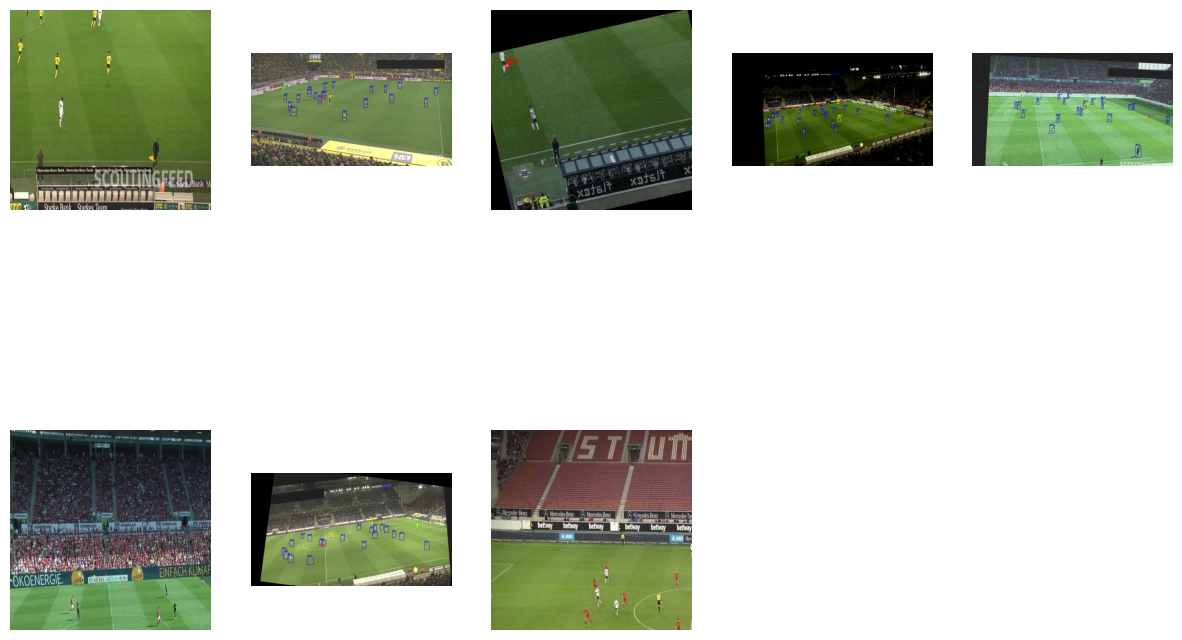

In [ ]:
import os, glob, random, shutil
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict

# مسیر دیتاست مرج شده
MERGED_DIR = "/content/drive/MyDrive/merged_football_dataset"
FINAL_DIR = "/content/drive/MyDrive/football_yolov8"

os.makedirs(FINAL_DIR, exist_ok=True)

# ---------------- نمایش رندوم نمونه‌ها ----------------
def read_yolo_labels(lbl_path):
    boxes = []
    if not os.path.exists(lbl_path): return boxes
    with open(lbl_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls, x, y, w, h = parts[:5]
                boxes.append((int(cls), float(x), float(y), float(w), float(h)))
    return boxes

def show_random_samples(n=6):
    all_imgs = glob.glob(os.path.join(MERGED_DIR, "images", "*"))
    sampled = random.sample(all_imgs, min(n, len(all_imgs)))
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(sampled):
        lbl_path = os.path.join(MERGED_DIR, "labels", os.path.splitext(os.path.basename(img_path))[0] + ".txt")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        boxes = read_yolo_labels(lbl_path)
        for cls, cx, cy, bw, bh in boxes:
            xmin, ymin = int((cx - bw/2)*w), int((cy - bh/2)*h)
            xmax, ymax = int((cx + bw/2)*w), int((cy + bh/2)*h)
            color = (255,0,0) if cls==0 else (0,255,0) if cls==1 else (0,0,255) if cls==2 else (255,255,0)
            cv2.rectangle(img, (xmin,ymin), (xmax,ymax), color, 2)
            cv2.putText(img, f"cls {cls}", (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        plt.subplot(2, n//2+1, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

# نمایش چند نمونه
show_random_samples(8)



In [ ]:
# ---------------- تقسیم به train/val/test ----------------
all_imgs = glob.glob(os.path.join(MERGED_DIR, "images", "*"))
data = []
for img in all_imgs:
    lbl = os.path.join(MERGED_DIR, "labels", os.path.splitext(os.path.basename(img))[0] + ".txt")
    boxes = read_yolo_labels(lbl)
    classes = [b[0] for b in boxes]
    data.append((img, lbl, classes))

# برای stratification، از کلاس غالب هر تصویر استفاده می‌کنیم
labels_for_split = [max(Counter(classes), key=Counter(classes).get) if classes else -1 for _,_,classes in data]

train_data, testval_data = train_test_split(data, test_size=0.3, stratify=labels_for_split, random_state=42)
val_data, test_data = train_test_split(testval_data, test_size=0.5, stratify=[max(Counter(c), key=Counter(c).get) if c else -1 for _,_,c in testval_data], random_state=42)

splits = {"train": train_data, "val": val_data, "test": test_data}

for split, items in splits.items():
    img_dir = os.path.join(FINAL_DIR, split, "images")
    lbl_dir = os.path.join(FINAL_DIR, split, "labels")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)
    for img, lbl, _ in items:
        shutil.copy2(img, os.path.join(img_dir, os.path.basename(img)))
        if os.path.exists(lbl):
            shutil.copy2(lbl, os.path.join(lbl_dir, os.path.basename(lbl)))
        else:
            open(os.path.join(lbl_dir, os.path.splitext(os.path.basename(img))[0] + ".txt"), 'w').close()

# ---------------- ساخت data.yaml ----------------
yaml_path = os.path.join(FINAL_DIR, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(f"train: {FINAL_DIR}/train/images\n")
    f.write(f"val: {FINAL_DIR}/val/images\n")
    f.write(f"test: {FINAL_DIR}/test/images\n\n")
    f.write("nc: 4\n")
    f.write("names: ['ball','player_class1','player_class2','player_class3']\n")

print("✅ دیتاست آماده شد در:", FINAL_DIR)
print("📄 فایل yaml ساخته شد:", yaml_path)


In [ ]:
import os, glob, random, shutil
import cv2
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

MERGED_DIR = "/content/drive/MyDrive/merged_football_dataset"
FINAL_DIR = "/content/drive/MyDrive/football_yolov8_balanced"

os.makedirs(FINAL_DIR, exist_ok=True)

# ----------- Helper ها -----------
def read_yolo_labels(lbl_path):
    boxes = []
    if not os.path.exists(lbl_path): return boxes
    with open(lbl_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls, x, y, w, h = parts[:5]
                boxes.append((int(cls), float(x), float(y), float(w), float(h)))
    return boxes

def count_bboxes(dataset):
    counter = Counter()
    for _, _, classes in dataset:
        counter.update(classes)
    return counter

# ----------- بارگذاری دیتاست -----------
all_imgs = glob.glob(os.path.join(MERGED_DIR, "images", "*"))
data = []
for img in all_imgs:
    lbl = os.path.join(MERGED_DIR, "labels", os.path.splitext(os.path.basename(img))[0] + ".txt")
    classes = [b[0] for b in read_yolo_labels(lbl)]
    data.append((img, lbl, classes))

print("📊 کل bboxها:", count_bboxes(data))

# ----------- تقسیم بالانس‌شده -----------
random.shuffle(data)

ratios = {"train": 0.7, "val": 0.15, "test": 0.15}
splits = {"train": [], "val": [], "test": []}
target_counts = {cls: int(cnt * ratios["train"]) for cls, cnt in count_bboxes(data).items()}
current_counts = {"train": Counter(), "val": Counter(), "test": Counter()}

for img, lbl, classes in data:
    # پیدا کردن splitی که این تصویر رو اضافه کنیم
    best_split, best_score = None, 1e9
    for split in ["train", "val", "test"]:
        score = 0
        for cls in classes:
            # penalize اگر این split در اون کلاس اشباع شده
            ratio_now = current_counts[split][cls] / max(1, target_counts.get(cls, 1))
            score += ratio_now
        if score < best_score:
            best_split, best_score = split, score
    splits[best_split].append((img, lbl, classes))
    current_counts[best_split].update(classes)

# ----------- کپی فایل‌ها به ساختار YOLOv8 -----------
for split, items in splits.items():
    img_dir = os.path.join(FINAL_DIR, split, "images")
    lbl_dir = os.path.join(FINAL_DIR, split, "labels")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)
    for img, lbl, _ in items:
        shutil.copy2(img, os.path.join(img_dir, os.path.basename(img)))
        if os.path.exists(lbl):
            shutil.copy2(lbl, os.path.join(lbl_dir, os.path.basename(lbl)))
        else:
            open(os.path.join(lbl_dir, os.path.splitext(os.path.basename(img))[0] + ".txt"), 'w').close()

# ----------- نمایش شمارش نهایی -----------
print("\n📊 شمارش نهایی bboxها:")
for split, items in splits.items():
    print(f"{split}: {count_bboxes(items)}")

# ----------- ساخت فایل yaml -----------
yaml_path = os.path.join(FINAL_DIR, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(f"train: {FINAL_DIR}/train/images\n")
    f.write(f"val: {FINAL_DIR}/val/images\n")
    f.write(f"test: {FINAL_DIR}/test/images\n\n")
    f.write("nc: 4\n")
    f.write("names: ['ball','player_class1','player_class2','player_class3']\n")

print("✅ دیتاست آماده شد در:", FINAL_DIR)
print("📄 فایل yaml ساخته شد:", yaml_path)


📊 کل bboxها: Counter({2: 109069, 3: 12082, 0: 9722, 1: 5240})

📊 شمارش نهایی bboxها:
train: Counter({2: 36355, 3: 4030, 0: 3241, 1: 1748})
val: Counter({2: 36364, 3: 4028, 0: 3241, 1: 1747})
test: Counter({2: 36350, 3: 4024, 0: 3240, 1: 1745})
✅ دیتاست آماده شد در: /content/drive/MyDrive/football_yolov8_balanced
📄 فایل yaml ساخته شد: /content/drive/MyDrive/football_yolov8_balanced/data.yaml


In [ ]:
!pip install -q ultralytics supervision opencv-python-headless pyyaml tensorboard numpy scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 17.6 MB/s eta 0:00:00


In [ ]:
# Cell 0: نصب وابستگی‌ها و mount کردن Drive
!pip install -U ultralytics tensorboard opencv-python-headless matplotlib tqdm seaborn --quiet


In [ ]:
# Cell 1: imports + تنظیم مسیرها و هایپرپارامترها
import os, glob, random, shutil, time
from pathlib import Path
import torch
import numpy as np
import math

from ultralytics import YOLO

# ---------- مسیرها (بررسی و اگر لازم تغییر بده) ----------
DRIVE_ROOT = "/content/drive/MyDrive"
DATA_YAML = f"{DRIVE_ROOT}/football_yolov8_balanced/data.yaml"   # خروجی قبلی شما
PROJECT_ROOT = f"{DRIVE_ROOT}/football_train_runs"
EXPERIMENT_BASE = "yolov8m_balanced"   # پایه اسم برای runها

os.makedirs(PROJECT_ROOT, exist_ok=True)

# ---------- هایپرپارامترها ----------
BASE_MODEL = "yolov8m.pt"   # انتخاب مدل: yolov8n / yolov8s / yolov8m / yolov8l / yolov8x
IMG_SIZE = 640
TOTAL_EPOCHS = 80
FROZEN_EPOCHS = 5
UNFROZEN_EPOCHS = TOTAL_EPOCHS - FROZEN_EPOCHS
BATCH = -1         # -1 => ultralytics auto-batch
WORKERS = 4
AMP = True
SAVE_PERIOD = 1    # ذخیره هر epoch (برای ایمنی روی Colab)
PATIENCE = 30
SEED = 42

device = 0 if torch.cuda.is_available() else 'cpu'
print("Device:", device)
print("DATA_YAML:", DATA_YAML)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("BASE MODEL:", BASE_MODEL)


Device: cpu
DATA_YAML: /content/drive/MyDrive/football_yolov8_balanced/data.yaml
PROJECT_ROOT: /content/drive/MyDrive/football_train_runs
BASE MODEL: yolov8m.pt


In [ ]:
# Cell 2: helper functions

def freeze_backbone_if_possible(yolo_model):
    """
    تلاش می‌کند backbone را فریز کند:
      1) اگر model.model.backbone وجود دارد از آن استفاده کند
      2) در غیر اینصورت پارامترهایی که نام 'backbone' در نام‌شان دارند فریز کند
    بازگردانده: تعداد پارامترهای فریز شده
    """
    m = yolo_model.model
    cnt = 0
    try:
        if hasattr(m, "backbone"):
            for p in m.backbone.parameters():
                p.requires_grad = False
                cnt += 1
            return cnt
    except Exception:
        pass
    # fallback by name
    for name, p in m.named_parameters():
        if "backbone" in name:
            p.requires_grad = False
            cnt += 1
    return cnt

def unfreeze_all(yolo_model):
    m = yolo_model.model
    for p in m.parameters():
        p.requires_grad = True

def find_checkpoint_for_run(project_root, run_name):
    """
    دنبال پوشه runs/train/{run_name}/weights/* می‌گردد و best.pt یا last.pt بازمی‌گرداند.
    """
    run_dir = os.path.join("runs", "train", run_name)  # ultralytics default run location
    if not os.path.isdir(run_dir):
        # شاید کاربران project=name convention، سعی کن داخل project_root هم نگاه کنیم
        run_dir = os.path.join(project_root, run_name)
        if not os.path.isdir(run_dir):
            # fallback: جستجوی run با همین prefix
            candidates = sorted(glob.glob(os.path.join("runs", "train", run_name+"*")) + glob.glob(os.path.join(project_root, run_name+"*")), key=os.path.getmtime)
            run_dir = candidates[-1] if candidates else None
    if not run_dir or not os.path.isdir(run_dir):
        return None
    weights_dir = os.path.join(run_dir, "weights")
    if not os.path.isdir(weights_dir):
        # sometimes ultralytics puts weights in run_dir/weights
        if os.path.isdir(os.path.join(run_dir, "weights")):
            weights_dir = os.path.join(run_dir, "weights")
        else:
            return None
    # prefer best.pt then last.pt
    best = os.path.join(weights_dir, "best.pt")
    last = os.path.join(weights_dir, "last.pt")
    if os.path.exists(best):
        return best
    if os.path.exists(last):
        return last
    # else try any pt
    pts = glob.glob(os.path.join(weights_dir, "*.pt"))
    return pts[-1] if pts else None

def backup_weights(run_name, dest_dir):
    run_dir = os.path.join("runs", "train", run_name)
    if not os.path.isdir(run_dir):
        return False
    dest = os.path.join(dest_dir, run_name + "_backup_" + time.strftime("%Y%m%d_%H%M%S"))
    shutil.copytree(run_dir, dest)
    print("Backed up run to", dest)
    return True

# reproducibility
import random; random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [ ]:
# Cell 3: Phase 1 — frozen training (backbone frozen)
RUN_FROZEN = f"{EXPERIMENT_BASE}_frozen"
print("Phase 1 run name:", RUN_FROZEN)

# load base model
model = YOLO(BASE_MODEL)

# freeze backbone (try)
frozen_count = freeze_backbone_if_possible(model)
print("Frozen parameters count (approx):", frozen_count)

# train frozen
print(f"Starting frozen training for {FROZEN_EPOCHS} epochs (run name={RUN_FROZEN}) ...")
model.train(
    data=DATA_YAML,
    epochs=FROZEN_EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    device=device,
    amp=AMP,
    project=PROJECT_ROOT,
    name=RUN_FROZEN,
    save_period=SAVE_PERIOD,
    workers=4,
    patience=PATIENCE,
    augment=True,
    seed=SEED
)

# After frozen training, find checkpoint
ckpt = find_checkpoint_for_run(PROJECT_ROOT, RUN_FROZEN)
print("Checkpoint from frozen run:", ckpt)
if ckpt is None:
    # try list runs
    print("Could not find checkpoint for frozen run. Look into runs/train/")
else:
    print("Found ckpt:", ckpt)


Phase 1 run name: yolov8m_balanced_frozen
Frozen parameters count (approx): 0
Starting frozen training for 5 epochs (run name=yolov8m_balanced_frozen) ...
Ultralytics 8.3.198 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/football_yolov8_balanced/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.

In [ ]:
# Cell 4: Phase 2 — load checkpoint and finetune (unfreeze)
RUN_FINETUNE = f"{EXPERIMENT_BASE}_finetune"
print("Phase 2 run name:", RUN_FINETUNE)

# find last ckpt from frozen run (if we didn't find earlier, retry)
ckpt = find_checkpoint_for_run(PROJECT_ROOT, RUN_FROZEN) or ckpt
if ckpt is None:
    raise RuntimeError("No checkpoint found from frozen run. Cannot start finetune. Please check runs/train/ for weights.")

# load model from checkpoint
print("Loading model from checkpoint:", ckpt)
model2 = YOLO(ckpt)

# unfreeze
try:
    unfreeze_all(model2.model)
    print("All parameters set requires_grad=True")
except Exception as e:
    print("Warning unfreeze failed:", e)

# train finetune for remaining epochs (new run name so no resume confusion)
print(f"Starting finetune for {UNFROZEN_EPOCHS} epochs (run name={RUN_FINETUNE}) ...")
model2.train(
    data=DATA_YAML,
    epochs=UNFROZEN_EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    device=device,
    amp=AMP,
    project=PROJECT_ROOT,
    name=RUN_FINETUNE,
    save_period=SAVE_PERIOD,
    workers=4,
    patience=PATIENCE,
    augment=True,
    seed=SEED
)

# After finetune, print final checkpoint path
final_ckpt = find_checkpoint_for_run(PROJECT_ROOT, RUN_FINETUNE)
print("Finetune final checkpoint:", final_ckpt)

# Optional: backup the finetune run folder to Drive location (safe)
backup_weights(RUN_FINETUNE, DRIVE_ROOT)


Phase 2 run name: yolov8m_balanced_finetune
Loading model from checkpoint: /content/drive/MyDrive/football_train_runs/yolov8m_balanced_frozen/weights/best.pt
All parameters set requires_grad=True
Starting finetune for 75 epochs (run name=yolov8m_balanced_finetune) ...
Ultralytics 8.3.198 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/football_yolov8_balanced/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l